## RL Autocomplete

In this notebook I'm going to show my process of making a reinforcement learning agent that will guess the next letter in a string and potentially use it for autocomplete. I decided to do this project because I wanted to do a non gaming related reinforcement learning project. I know that there are better ways to do autocomplete but I'm curious if reinforcement learning would work. The project will be using a PPO model that I will create using pytorch and chatgpt. The reason for this choice is because I used a PPO model in my previous project and I want to get a better understanding of how it works

First I made the pytorch module. Initially I was using convolutional layers in my module but those are usually used for pattern recognision like machine vision. I learned about convolutional layers so it wasn't too bad. I found that most people use linear layers so my module also uses linear layers. If at any point the module seems to be insufficient I will update it.



In [2]:
import torch.nn as nn

class ActorCritic(nn.Module):

    def __init__(self, nb_actions):
        super().__init__()
        self.head = nn.Sequential(nn.Linear(4, 64), nn.Tanh(), nn.Linear(64, 64), nn.Tanh())
        self.actor = nn.Sequential(nn.Linear(64, nb_actions))
        self.critic = nn.Sequential(nn.Linear(64, 1))
    
    def forward(self, x):
        h = self.head(x)
        return self.actor(h), self.critic(h)

With the help of chatgpt I made the PPO agent. the parameters are as follows
- **nb_actions:** the number of actions the agent can take
- **device:** the device that the model is bein run on
- **gamma:** discount factor
- **lam:** GAE(Generalized Advantage Estimation) lambda
- **clip_eps:** PPO clipping parameter, 0.2 is fine in almost all cases
- **lr:** learning rate
- **epochs:** how many times to pass through data per update
- **batch_size:** size of mini batches

the **get_action_and_value** function takes in a state and returns an action, the log probability of the action and the estimated value of the action

the **compute_gae** function calculates the returns using GAE

the **ppo_update** function performs the policy and value function update

In [3]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.distributions import Categorical

class PPOAgent:
    def __init__(self, nb_actions, device='cpu', gamma=0.99, lam=0.95, clip_eps=0.2, lr=2.5e-4, epochs=4, batch_size=64):
        self.device = device
        self.gamma = gamma
        self.lam = lam
        self.clip_eps = clip_eps
        self.epochs = epochs
        self.batch_size = batch_size

        self.model = ActorCritic(nb_actions).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def get_action_and_value(self, state):
        logits, value = self.model(state)
        dist = Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action, log_prob, value.squeeze(-1)

    def compute_gae(self, rewards, values, dones, next_value):
        values = np.append(values, next_value)
        gae = 0
        returns = []
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * values[t + 1] * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * self.lam * (1 - dones[t]) * gae
            returns.insert(0, gae + values[t])
        return returns

    def ppo_update(self, states, actions, log_probs, returns, values):
        advantages = returns - values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        for _ in range(self.epochs):
            indices = np.arange(len(states))
            np.random.shuffle(indices)

            for i in range(0, len(states), self.batch_size):
                idx = indices[i:i+self.batch_size]
                s_batch = torch.tensor(states[idx], dtype=torch.float32).to(self.device)
                a_batch = torch.tensor(actions[idx]).to(self.device)
                old_log_probs_batch = torch.tensor(log_probs[idx]).to(self.device)
                ret_batch = torch.tensor(returns[idx], dtype=torch.float32).to(self.device)
                adv_batch = torch.tensor(advantages[idx], dtype=torch.float32).to(self.device)

                logits, value = self.model(s_batch)
                dist = Categorical(logits=logits)
                entropy = dist.entropy().mean()
                new_log_probs = dist.log_prob(a_batch)

                ratio = (new_log_probs - old_log_probs_batch).exp()
                surr1 = ratio * adv_batch
                # Clipping for stability
                surr2 = torch.clamp(ratio, 1.0 - self.clip_eps, 1.0 + self.clip_eps) * adv_batch

                policy_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.mse_loss(value.squeeze(-1), ret_batch)
                loss = policy_loss + 0.5 * value_loss - 0.01 * entropy

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

Before starting on the autocomplete agent I wanted to test if the PPO agent even works. It would be annoying if I didn't know if a bug was caused by my agent or my training. I created a script for loading a gymnasium environment and training the PPO agent. An interesting thing to note from the script is that the agent only gets trained after 50 experiences. this is because of the way PPO works. first the agent will collect an amount of experiences based on the current policy and then the agent gets trained on those experiences. unlike Q-learning, these experiences are discarded after training.

In [23]:
import gymnasium as gym
import numpy as np
import torch

env = gym.make('CartPole-v1')
agent = PPOAgent(nb_actions=env.action_space.n)

max_episodes = 3000
max_steps = 500

for episode in range(max_episodes):
    state, _ = env.reset()
    states, actions, log_probs, rewards, dones, values = [], [], [], [], [], []

    
    for _ in range(max_steps):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0)
        action_tensor, log_prob, value = agent.get_action_and_value(state_tensor)
        action = int(action_tensor)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated


        states.append(state)
        actions.append(action)
        log_probs.append(log_prob.item())
        rewards.append(reward)
        dones.append(done)
        values.append(value.item())

        state = next_state
        if done:
            break

    next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
    _, _, next_value = agent.get_action_and_value(next_state_tensor)
    returns = agent.compute_gae(rewards, values, dones, next_value.item())

    agent.ppo_update(
        np.array(states),
        np.array(actions),
        np.array(log_probs),
        np.array(returns),
        np.array(values)
    )

    total_reward = sum(rewards)
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")

Episode 1: Total Reward = 23.0
Episode 2: Total Reward = 11.0
Episode 3: Total Reward = 38.0
Episode 4: Total Reward = 22.0
Episode 5: Total Reward = 22.0
Episode 6: Total Reward = 12.0
Episode 7: Total Reward = 25.0
Episode 8: Total Reward = 10.0
Episode 9: Total Reward = 11.0
Episode 10: Total Reward = 22.0
Episode 11: Total Reward = 12.0
Episode 12: Total Reward = 22.0
Episode 13: Total Reward = 26.0
Episode 14: Total Reward = 23.0
Episode 15: Total Reward = 14.0
Episode 16: Total Reward = 14.0
Episode 17: Total Reward = 19.0
Episode 18: Total Reward = 19.0
Episode 19: Total Reward = 28.0
Episode 20: Total Reward = 19.0
Episode 21: Total Reward = 12.0
Episode 22: Total Reward = 11.0
Episode 23: Total Reward = 29.0
Episode 24: Total Reward = 31.0
Episode 25: Total Reward = 19.0
Episode 26: Total Reward = 14.0
Episode 27: Total Reward = 24.0
Episode 28: Total Reward = 9.0
Episode 29: Total Reward = 55.0
Episode 30: Total Reward = 17.0
Episode 31: Total Reward = 62.0
Episode 32: Total 

Looking at the reward, you can see that the agent gets properly trained. Now I can start with the autocomplete. While looking for a good dataset on kaggle, I found a english word frequency [dataset](https://www.kaggle.com/datasets/rtatman/english-word-frequency/data) containing 333333 of the most frequently used words according to Google Web Trillion Word Corpus. I want to remove all single letter words from the dataset as most of these are most likely accidental searches and there is no point on training the agent on single letters as there is no second letter to predict. I also removed words longer than 16 characters so I could later on pad all words to a reasonable size. 10 was a bit too short as some common words will be longer than 10 character but 15 was way more reasonable.

I wrote a small script that loads in the dataset into a dataframe using pandas, creates a new dataframe containing all rows where the word length is longer than one and and shorter than 16 and saves it to a new file.

In [24]:
import pandas as pd

input_file = "dataset.csv"
output_file = "dataset_clean.csv"

df = pd.read_csv(input_file)
df_filtered = df[(df['word'].str.len() > 1) & (df['word'].str.len() <= 15)]

df_filtered.to_csv(output_file, index=False)

My plan for training is taking a random word from the dataset, giving a small portion of the word to the agent as the state, having the agent guess the next letter and then checking if the guess is correct. If the agent gets the answer right, it will get 1 reward, otherwise it doesn't get any rewards.

I'm planning on converting the characters to integers. I hope that this way the agent will be better at understanding the alphabet. encoding like this is already widely [used](https://www.iterate.ai/ai-glossary/what-is-encode-technology) in generative AI

Here's the code I use to create 2 maps for converting between the characters and the integers

In [25]:
alphabet = list("abcdefghijklmnopqrstuvwxyz")
char_to_int = {c: i for i, c in enumerate(alphabet)}
idx_to_char = {i: c for c, i in char_to_int.items()}
vocab_size = len(alphabet)

print(char_to_int)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25}


Now I have a finished basic training loop, one problem I ran into though is that my torch module did not support the encoded text that I was providing it. I had to update it to fix this issue. The new module now adds an embedding layer. the sizes of the linear layers are also adjusted to fit.

In [4]:
class ActorCriticV2(nn.Module):

    def __init__(self, nb_actions, embed_dim=32, hidden_size=64):
        super().__init__()
        self.embedding = nn.Embedding(nb_actions, embed_dim)
        self.rnn = nn.GRU(embed_dim, hidden_size, batch_first=True)

        self.head = nn.Sequential(
            nn.Linear(hidden_size, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh()
        )
        self.actor = nn.Linear(64, nb_actions)
        self.critic = nn.Linear(64, 1)
    
    def forward(self, x):
        x = self.embedding(x)
        _, h = self.rnn(x)
        h = h.squeeze(0)

        h = self.head(h)
        return self.actor(h), self.critic(h)

I also had to update the PPOAgent because it was converting the states to float which was causing an error with the updated module.

In [5]:
import torch
import numpy as np

class PPOAgentV2:
    def __init__(self, nb_actions, device='cpu', gamma=0.99, lam=0.95, clip_eps=0.2, lr=2.5e-4, epochs=4, batch_size=64):
        self.device = device
        self.gamma = gamma
        self.lam = lam
        self.clip_eps = clip_eps
        self.epochs = epochs
        self.batch_size = batch_size

        self.model = ActorCriticV2(nb_actions).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def get_action_and_value(self, state):
        logits, value = self.model(state)
        dist = Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action, log_prob, value.squeeze(-1)

    def compute_gae(self, rewards, values, dones, next_value):
        values = np.append(values, next_value)
        gae = 0
        returns = []
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * values[t + 1] * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * self.lam * (1 - dones[t]) * gae
            returns.insert(0, gae + values[t])
        return returns

    def ppo_update(self, states, actions, log_probs, returns, values):
        advantages = returns - values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        for _ in range(self.epochs):
            indices = np.arange(len(states))
            np.random.shuffle(indices)

            for i in range(0, len(states), self.batch_size):
                idx = indices[i:i+self.batch_size]
                s_batch = torch.tensor(states[idx]).to(self.device) # Removed dtype=torch.float32 here to fix the crash
                a_batch = torch.tensor(actions[idx]).to(self.device)
                old_log_probs_batch = torch.tensor(log_probs[idx]).to(self.device)
                ret_batch = torch.tensor(returns[idx], dtype=torch.float32).to(self.device)
                adv_batch = torch.tensor(advantages[idx], dtype=torch.float32).to(self.device)

                logits, value = self.model(s_batch)
                dist = Categorical(logits=logits)
                entropy = dist.entropy().mean()
                new_log_probs = dist.log_prob(a_batch)

                ratio = (new_log_probs - old_log_probs_batch).exp()
                surr1 = ratio * adv_batch
                # Clipping for stability
                surr2 = torch.clamp(ratio, 1.0 - self.clip_eps, 1.0 + self.clip_eps) * adv_batch

                policy_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.mse_loss(value.squeeze(-1), ret_batch)
                loss = policy_loss + 0.5 * value_loss - 0.01 * entropy

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

Here is the training loop that I made the updated PPOAgent for

In [28]:
import torch
import random
import numpy as np
import pandas as pd

max_seq_len = 15
device = 'cuda' if torch.cuda.is_available() else 'cpu'

alphabet = list("abcdefghijklmnopqrstuvwxyz")
PAD_IDX = len(alphabet)  # 26
char_to_int = {c: i for i, c in enumerate(alphabet)}
int_to_char = {i: c for i, c in enumerate(alphabet)}
vocab_size = len(alphabet) + 1  # +1 for PAD

agent = PPOAgentV2(nb_actions=vocab_size, device=device)

words = pd.read_csv("dataset_clean.csv")['word'].str.lower().tolist()
words = [w for w in words if w.isalpha()]

for epoch in range(10): # made this shorter in the notebook for showcasing
    states, actions, log_probs, rewards, values, dones = [], [], [], [], [], []
    
    for _ in range(50):  # steps per epoch
        word = random.choice(words)
        for t in range(len(word) - 1):
            partial = word[:t]
            target_char = word[t]

            # Encode partial word
            state = [char_to_int[c] for c in partial]
            pad_len = max_seq_len - len(state)
            state += [PAD_IDX] * pad_len  # pad with PAD_IDX
            state_tensor = torch.tensor([state], dtype=torch.long).to(device)  # shape: [1, max_seq_len]

            # Get action from PPO
            action, log_prob, value = agent.get_action_and_value(state_tensor)
            guessed_char = int_to_char.get(action.item(), '?')
            correct = guessed_char == target_char
            reward = 1 if correct else 0

            # Store experience
            states.append(state)
            actions.append(action.item())
            log_probs.append(log_prob.item())
            rewards.append(reward)
            values.append(value.item())
            dones.append(False)

        dones[-1] = True  # End of word is end of episode

    # Bootstrap value for last step
    next_state = torch.tensor([states[-1]], dtype=torch.long).to(device)
    _, _, next_value = agent.get_action_and_value(next_state)
    returns = agent.compute_gae(rewards, values, dones, next_value.item())

    # Convert to arrays
    states = torch.tensor(states, dtype=torch.long)
    actions = np.array(actions)
    log_probs = np.array(log_probs)
    returns = np.array(returns)
    values = np.array(values)

    agent.ppo_update(states, actions, log_probs, returns, values)

    avg_reward = np.mean(rewards)
    print(f"Epoch {epoch}: Avg reward per step: {avg_reward:.2f}")

C:\Users\ralf2\AppData\Local\Temp\ipykernel_22420\93846100.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_batch = torch.tensor(states[idx]).to(self.device) # Removed dtype=torch.float32 here to fix the crash


Epoch 0: Avg reward per step: 0.04
Epoch 1: Avg reward per step: 0.03
Epoch 2: Avg reward per step: 0.02
Epoch 3: Avg reward per step: 0.04
Epoch 4: Avg reward per step: 0.04
Epoch 5: Avg reward per step: 0.03
Epoch 6: Avg reward per step: 0.02
Epoch 7: Avg reward per step: 0.03
Epoch 8: Avg reward per step: 0.03
Epoch 9: Avg reward per step: 0.04


The training loop now runs but my model cannot be saved at this point. I want to add saving/loading with a potential autosave every few episodes/epochs so I can test the model later for validation and train saved models more.

I added a saving and loading function to my PPOAgent. they use the **torch.save** and **torch.load** functions to save/load the model, optimizer and parameters

In [6]:
class PPOAgentV3:
    def __init__(self, nb_actions, device='cpu', gamma=0.99, lam=0.95, clip_eps=0.2, lr=2.5e-4, epochs=4, batch_size=64):
        self.device = device
        self.gamma = gamma
        self.lam = lam
        self.clip_eps = clip_eps
        self.epochs = epochs
        self.batch_size = batch_size

        self.model = ActorCriticV2(nb_actions).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def save(self, path):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'hyperparams': {
                'gamma': self.gamma,
                'lam': self.lam,
                'clip_eps': self.clip_eps,
                'epochs': self.epochs,
                'batch_size': self.batch_size
            }
        }, path)
    
    def load(self, path):
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        h = checkpoint.get('hyperparams', {})
        self.gamma = h.get('gamma', self.gamma)
        self.lam = h.get('lam', self.lam)
        self.clip_eps = h.get('clip_eps', self.clip_eps)
        self.epochs = h.get('epochs', self.epochs)
        self.batch_size = h.get('batch_size', self.batch_size)

    def get_action_and_value(self, state):
        logits, value = self.model(state)
        dist = Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action, log_prob, value.squeeze(-1)

    def compute_gae(self, rewards, values, dones, next_value):
        values = np.append(values, next_value)
        gae = 0
        returns = []
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * values[t + 1] * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * self.lam * (1 - dones[t]) * gae
            returns.insert(0, gae + values[t])
        return returns

    def ppo_update(self, states, actions, log_probs, returns, values):
        advantages = returns - values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        for _ in range(self.epochs):
            indices = np.arange(len(states))
            np.random.shuffle(indices)

            for i in range(0, len(states), self.batch_size):
                idx = indices[i:i+self.batch_size]
                s_batch = torch.tensor(states[idx]).to(self.device)
                a_batch = torch.tensor(actions[idx]).to(self.device)
                old_log_probs_batch = torch.tensor(log_probs[idx]).to(self.device)
                ret_batch = torch.tensor(returns[idx], dtype=torch.float32).to(self.device)
                adv_batch = torch.tensor(advantages[idx], dtype=torch.float32).to(self.device)

                logits, value = self.model(s_batch)
                dist = Categorical(logits=logits)
                entropy = dist.entropy().mean()
                new_log_probs = dist.log_prob(a_batch)

                ratio = (new_log_probs - old_log_probs_batch).exp()
                surr1 = ratio * adv_batch
                surr2 = torch.clamp(ratio, 1.0 - self.clip_eps, 1.0 + self.clip_eps) * adv_batch

                policy_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.mse_loss(value.squeeze(-1), ret_batch)

                loss = policy_loss + 0.5 * value_loss - 0.01 * entropy

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

I then updated my training loop so it would save the model every 20 epochs. I trained the model overnight and after about 8160 epochs I ended up with 0.20 average reward. The reward was aroung 0.9 when I started and got up to about 0.15 after 30 minutes so it looks like I've hit some sort of limitation, either because the training data is too large or because my pytorch module could be inadequate. It might also just not be possible to get to 1 average reward because 2 words can start the same but still have a different next letter. at that point it is just up to the agent as to what next letter gets chosen

I made a script that allows me to input part of a word and have the agent pick the next letter for me. Even though the average reward is only about 0.20, it is still able to finish some words and in cases where it is wrong it often still picks a letter that could make sense

In [30]:
# Constants
max_seq_len = 15
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Character mappings
alphabet = list("abcdefghijklmnopqrstuvwxyz")
PAD_IDX = len(alphabet)  # 26
char_to_int = {c: i for i, c in enumerate(alphabet)}
int_to_char = {i: c for i, c in enumerate(alphabet)}

# Load the trained agent
agent = PPOAgentV3(nb_actions=len(alphabet) + 1, device=device)
agent.load('./training/model1/ppo_checkpoint_epoch_8160.pth')  # path to saved checkpoint with highest count

def predict_next_char(partial_word: str) -> str:
    partial_word = partial_word.lower()
    encoded = [char_to_int.get(c, PAD_IDX) for c in partial_word if c in char_to_int]
    if len(encoded) > max_seq_len:
        encoded = encoded[-max_seq_len:]  # keep only last max_seq_len characters
    else:
        encoded += [PAD_IDX] * (max_seq_len - len(encoded))  # pad to fixed length

    state_tensor = torch.tensor([encoded], dtype=torch.long).to(device)
    action, _, _ = agent.get_action_and_value(state_tensor)

    return int_to_char.get(action.item(), '')

if __name__ == "__main__":
    print("Word: alie")
    predicted_char = predict_next_char("alie")
    print(f"Predicted next character: {predicted_char}")

    print("Word: quarmir")
    predicted_char = predict_next_char("quagmir")
    print(f"Predicted next character: {predicted_char}")

    print("Word: past")
    predicted_char = predict_next_char("past")
    print(f"Predicted next character: {predicted_char}")

    print("Word: pirat")
    predicted_char = predict_next_char("pirat")
    print(f"Predicted next character: {predicted_char}")

Word: alie
Predicted next character: n
Word: quarmir
Predicted next character: e
Word: past
Predicted next character: e
Word: pirat
Predicted next character: i


Now that I have the trained model and I can get it to generate a next letter, I need to validate it to see how reliable it is. I already know from training that it isn't super reliable but it would be better to get a calculated estimate for reliablility

In [7]:
import random
import torch
import pandas as pd

max_seq_len = 15
device = 'cuda' if torch.cuda.is_available() else 'cpu'

alphabet = list("abcdefghijklmnopqrstuvwxyz")
PAD_IDX = len(alphabet)  # 26
char_to_int = {c: i for i, c in enumerate(alphabet)}
int_to_char = {i: c for i, c in enumerate(alphabet)}
vocab_size = len(alphabet) + 1  # +1 for PAD

agent = PPOAgentV3(nb_actions=vocab_size, device=device)
agent.load('./training/model1/ppo_checkpoint_epoch_8160.pth')

words = pd.read_csv("dataset_clean.csv")['word'].str.lower().tolist()
words = [w for w in words if w.isalpha()]

def validate(agent, words, num_samples=1000):
    correct_guesses = 0
    total_guesses = 0

    with torch.no_grad(): # might not be nessecary since the agent only trains when I call the update ppo function
        for _ in range(num_samples):
            word = random.choice(words)
            
            t = random.randint(1, len(word) - 1) # get random part of word, don't need to check for every part of the word

            partial = word[:t]
            target_char = word[t]

            # Encode partial wordc
            state = [char_to_int[c] for c in partial]
            pad_len = max_seq_len - len(state)
            state += [PAD_IDX] * pad_len
            state_tensor = torch.tensor([state], dtype=torch.long).to(device)

            # Get action
            action, _, _ = agent.get_action_and_value(state_tensor)
            guessed_char = int_to_char.get(action.item(), '?')
            if guessed_char == target_char:
                correct_guesses += 1
            total_guesses += 1    

    accuracy = correct_guesses / total_guesses if total_guesses > 0 else 0
    return accuracy, correct_guesses, total_guesses

accuracy, correct_guesses, total_guesses = validate(agent, words, 1000)
print(f"Validation Accuracy: {accuracy:.4f} ({correct_guesses}/{total_guesses})")

Validation Accuracy: 0.2090 (209/1000)


After testing the agent, it got 209/1000 characters correct. This can definitely be improved but it is still pretty good for such a weird idea. This project so far has made me believe that using reinforcement learning for guessing letters might actually work out if executed better.

I want to collect more data from the agent to see how it performs, I think checking accuracy for each letter position would be interesting to look at and maybe check which letter gets correctly guessed the most

The first change I made was collecting all guessed characters, the correct guessed characters and missed guessed character. Missed guessed characters are the characters that the agent didn't guess correctly. I then create a bar graph with matplotlib

Validation Accuracy: 0.2060 (206/1000)


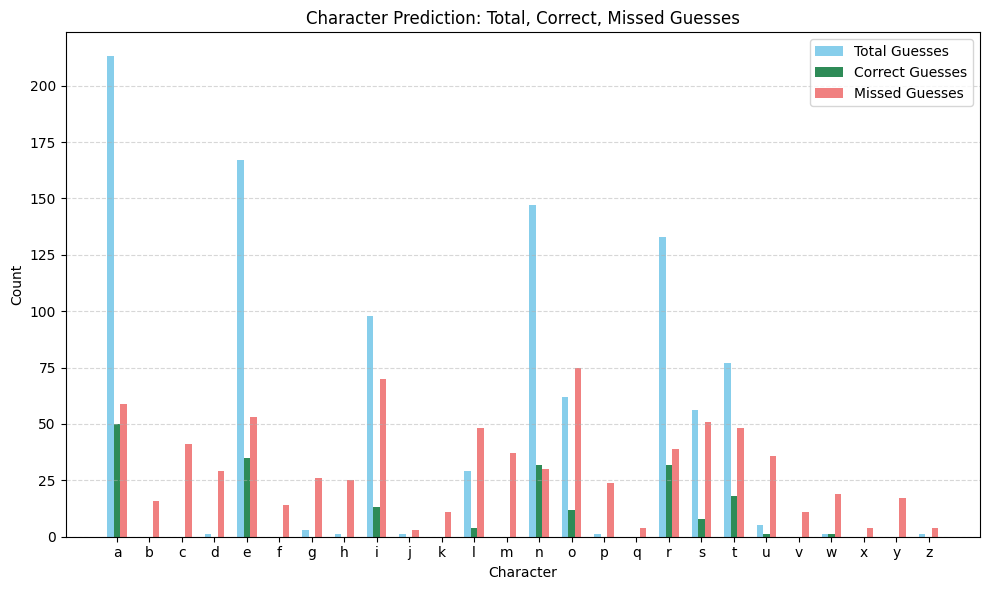

In [8]:
import random
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PPO import PPOAgent

max_seq_len = 15
device = 'cuda' if torch.cuda.is_available() else 'cpu'

alphabet = list("abcdefghijklmnopqrstuvwxyz")
PAD_IDX = len(alphabet)  # 26
char_to_int = {c: i for i, c in enumerate(alphabet)}
int_to_char = {i: c for i, c in enumerate(alphabet)}
vocab_size = len(alphabet) + 1  # +1 for PAD

agent = PPOAgentV3(nb_actions=vocab_size, device=device)
agent.load('./training/model1/ppo_checkpoint_epoch_8160.pth')

words = pd.read_csv("dataset_clean.csv")['word'].str.lower().tolist()
words = [w for w in words if w.isalpha()]

def validate(agent, words, num_samples=1000):
    char_correct = {}
    char_total = {}
    char_missed = {}
    correct_guesses = 0
    total_guesses = 0

    with torch.no_grad(): # might not be nessecary since the agent only trains when I call the update ppo function
        for _ in range(num_samples):
            word = random.choice(words)
            
            t = random.randint(1, len(word) - 1) # get random part of word, don't need to check for every part of the word

            partial = word[:t]
            target_char = word[t]

            # Encode partial wordc
            state = [char_to_int[c] for c in partial]
            pad_len = max_seq_len - len(state)
            state += [PAD_IDX] * pad_len
            state_tensor = torch.tensor([state], dtype=torch.long).to(device)

            # Get action
            action, _, _ = agent.get_action_and_value(state_tensor)
            guessed_char = int_to_char.get(action.item(), '?')
            if guessed_char not in char_total:
                char_total[guessed_char] = 0
            char_total[guessed_char] += 1
            if guessed_char == target_char:
                correct_guesses += 1
                if guessed_char not in char_correct:
                    char_correct[guessed_char] = 0
                char_correct[guessed_char] += 1
            else:
                if target_char not in char_missed:
                    char_missed[target_char] = 0
                char_missed[target_char] += 1
            total_guesses += 1    

    accuracy = correct_guesses / total_guesses if total_guesses > 0 else 0
    return accuracy, correct_guesses, total_guesses, char_correct, char_missed, char_total

accuracy, correct_guesses, total_guesses, char_correct, char_missed, char_total = validate(agent, words, 1000)
print(f"Validation Accuracy: {accuracy:.4f} ({correct_guesses}/{total_guesses})")

all_chars = sorted(
    c for c in (set(char_total.keys()) | set(char_correct.keys()) | set(char_missed.keys()))
    if c != '?'
)
total_counts = [char_total.get(c, 0) for c in all_chars]
correct_counts = [char_correct.get(c, 0) for c in all_chars]
missed_counts = [char_missed.get(c, 0) for c in all_chars]

# Bar positions
x = np.arange(len(all_chars)) * 1.5  # Add space between character groups
width = 0.3

plt.figure(figsize=(10, 6))
plt.bar(x - width, total_counts, width, label='Total Guesses', color='skyblue')
plt.bar(x, correct_counts, width, label='Correct Guesses', color='seagreen')
plt.bar(x + width, missed_counts, width, label='Missed Guesses', color='lightcoral')

# Labels and formatting
plt.xlabel('Character')
plt.ylabel('Count')
plt.title('Character Prediction: Total, Correct, Missed Guesses')
plt.xticks(ticks=x, labels=all_chars)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

From looking at the bar graph, you can see that most of the agents correct guesses are vowels. but suprisingly it also guessed correctly for certain constants. though if you look at the overall guesses it looks like the agent is stuck trying to pick the same letters. It makes sense that the agent wouldn't pick certain uncommon letters like q x and z a lot but even b c and d are rarely chosen.

I'm also not too sure if a grouped bar chart was a good idea, the bars ar very small and the whole graph feels cluttered.